2014-12-30, (MA Period ?) Ending Value 1050.50


Start date,2010-01-04
End date,2014-12-30
Total months,59
,Backtest
Annual return,0.993%
Cumulative returns,5.05%
Annual volatility,4.805%
Sharpe ratio,0.23
Calmar ratio,0.13
Stability,0.33
Max drawdown,-7.64%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.64,2013-02-01,2014-11-03,NaT,NaN
1,4.82,2011-10-28,2012-06-11,2012-09-06,225
2,4.00,2010-04-23,2010-08-16,2010-10-15,126
3,2.95,2011-05-02,2011-07-18,2011-09-15,99
4,2.69,2012-09-17,2012-12-13,2013-01-10,84


Stress Events,mean,min,max
EZB IR Event,-0.05%,-0.76%,0.41%
Flash Crash,-0.02%,-0.10%,0.00%
Apr14,-0.05%,-0.96%,0.69%


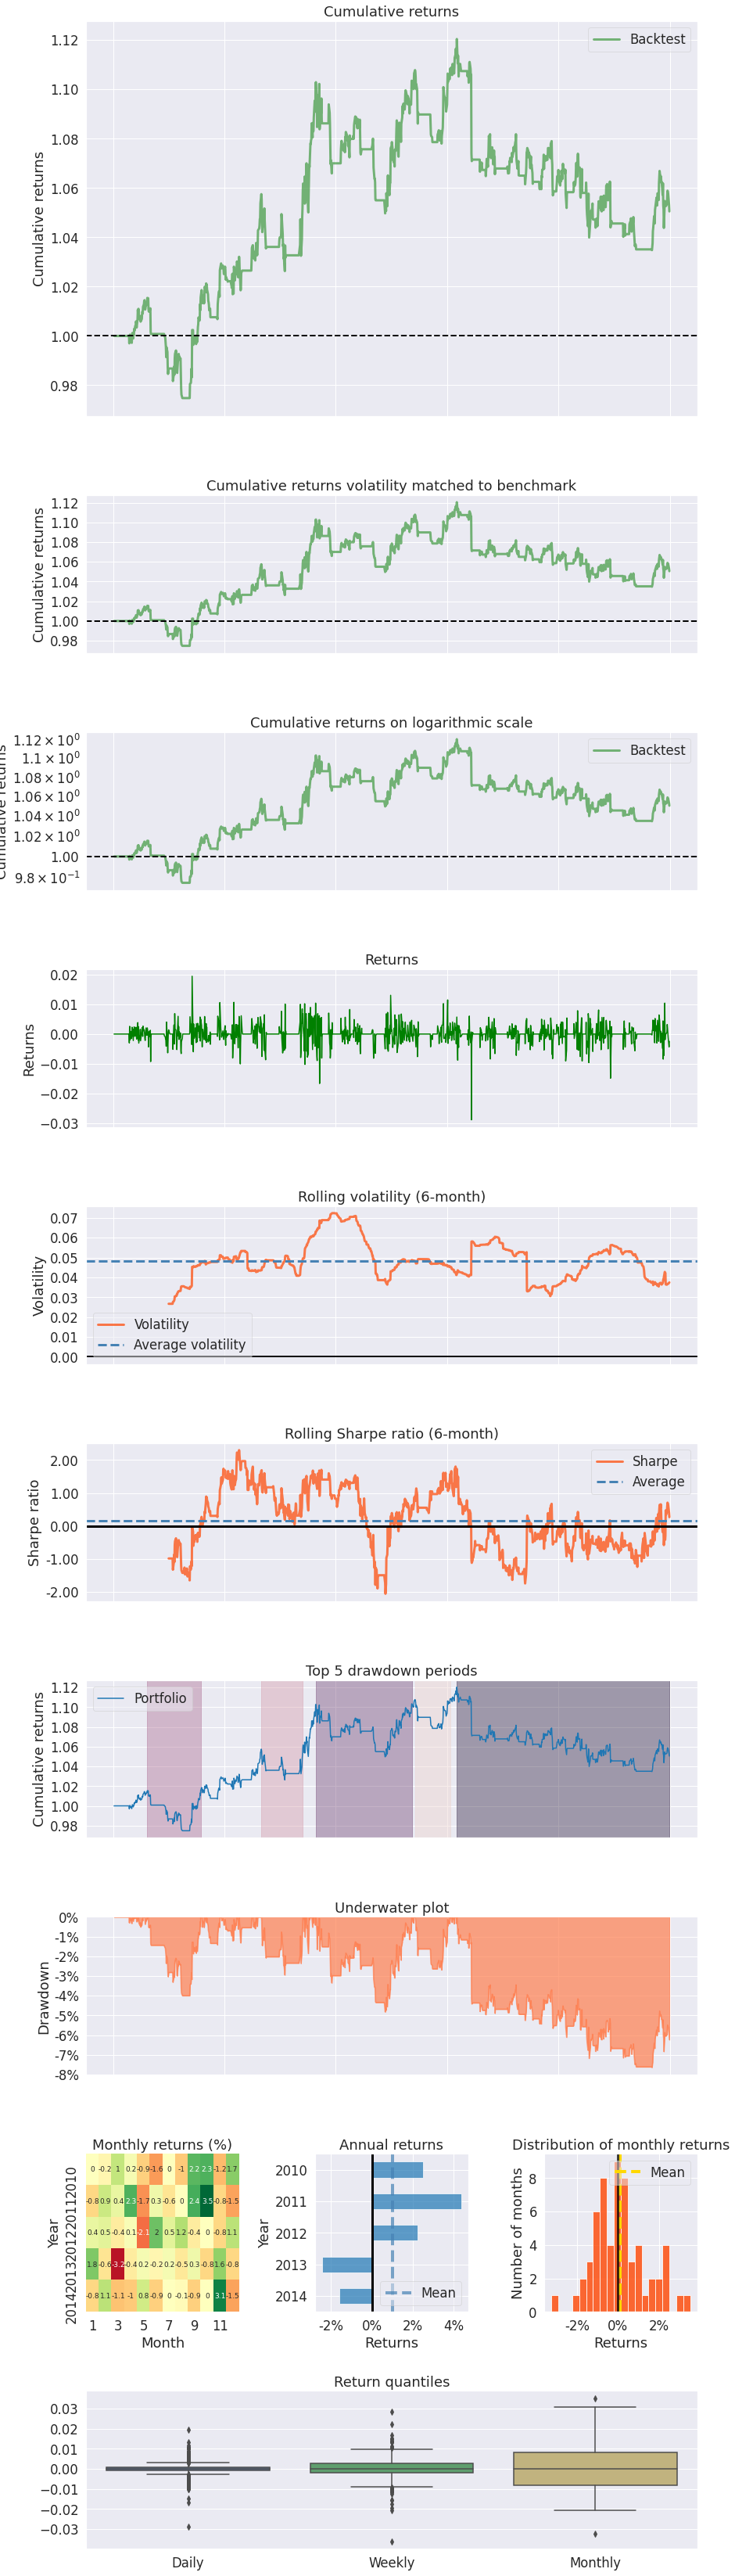

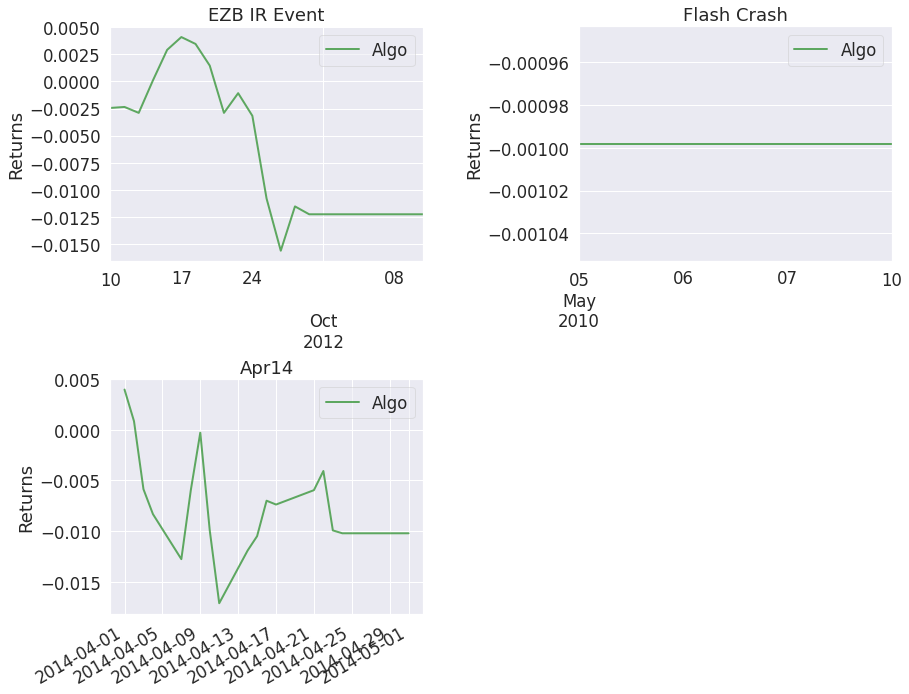

In [5]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime
import os.path
import sys
import backtrader as bt
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
import pyfolio as pf
import warnings; warnings.simplefilter('ignore')
from strategies.crossover_9_21_with_swing import Crossover9_21WithSwing

cerebro = bt.Cerebro()
cerebro.addstrategy(Crossover9_21WithSwing, printlog=False)

datapath = './data/test_data.txt'
data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    fromdate=datetime.datetime(2010, 1, 1),
    todate=datetime.datetime(2014, 12, 31),
    reverse=False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcommission(commission=0.0)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

pf.create_full_tear_sheet(returns)
